# 30 Doradus yellow lines: 5400 Å to 6300 Å

In [ ]:
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from mpdaf.obj import Cube
import regions
import sys

sys.path.append("../lib")
import moments
import extract

sns.set_context("talk")
sns.set_color_codes()

In [2]:
cubeA = Cube("../big-data/lmc-30dor-A-subcube-54-63.fits")
cubeB = Cube("../big-data/lmc-30dor-B-subcube-54-63.fits")
cubeC = Cube("../big-data/lmc-30dor-C-subcube-54-63.fits")
cubeD = Cube("../big-data/lmc-30dor-D-subcube-54-63.fits")

## Inspect the average spectrum for each field

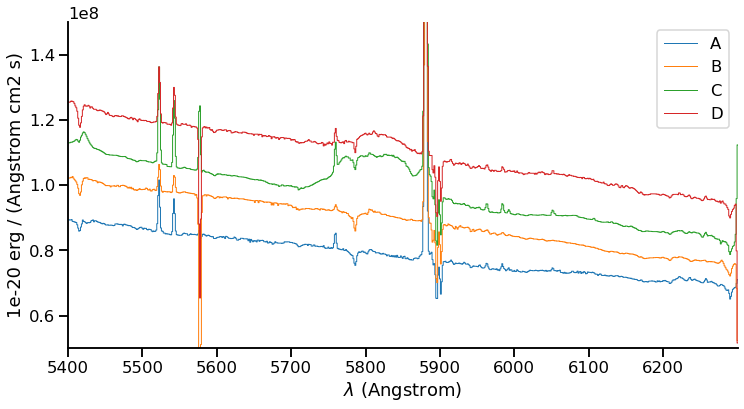

In [4]:
fig, ax = plt.subplots(figsize=(12, 6))
for cube, label in zip([cubeA, cubeB, cubeC, cubeD], "ABCD"):
    cube.sum(axis=(1, 2)).plot(label=label)
ax.legend()
ax.set(
    ylim=[0.5e8, 1.5e8],
)
sns.despine()

Again, we get WR features (I think)  around 5800.  We can also see the DIB 5781 absorption. 

## Define continuum wavelength ranges

We can try the same wav ranges as we used for NGC 346

In [14]:
wavranges = [
    (5470, 5510),
    (5550, 5570),
    (5600, 5700),
    (6000, 6030), (6070, 6100),
    (6180, 6220), (6260, 6280),
]

In [15]:
nv, ny, nx = cubeA.data.shape
ny, nx

(321, 319)

Split each field up into 4 roughly equal tiles:

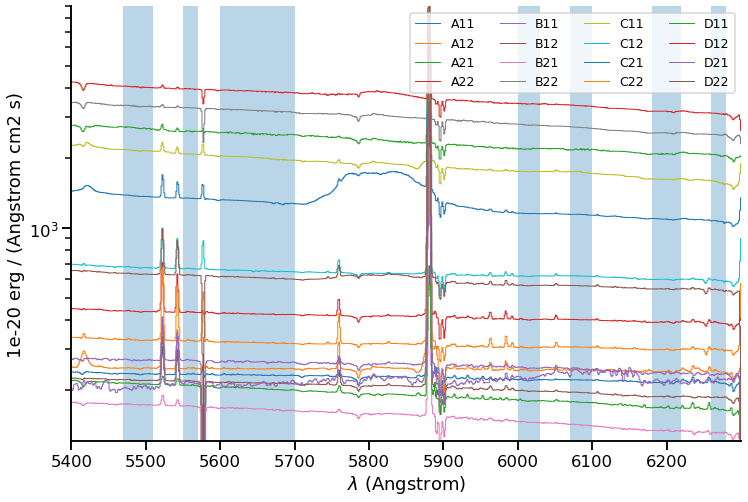

In [16]:
mm = 160  # middle of each image
fig, ax = plt.subplots(figsize=(12, 8))
for cube, label in zip([cubeA, cubeB, cubeC, cubeD], "ABCD"):
    cu11 = cube[:, :mm, :mm]
    cu12 = cube[:, :mm, mm:]
    cu21 = cube[:, mm:, :mm]
    cu22 = cube[:, mm:, mm:]
    cu11.mean(axis=(1, 2)).plot(label=f"{label}11")
    cu12.mean(axis=(1, 2)).plot(label=f"{label}12")
    cu21.mean(axis=(1, 2)).plot(label=f"{label}21")
    cu22.mean(axis=(1, 2)).plot(label=f"{label}22")

for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.legend(ncol=4, fontsize="x-small")
ax.set(
    yscale="log",
    ylim=[120, 9e3],
)
sns.despine()

## Test the polynomial fitting with field A

This takes about a minute for each field.

In [17]:
contA = extract.fit_continuum(
    cubeA,
    wav_ranges=wavranges,
    deg=5,
    median=False,
)

extract.fit_continuum: row 0


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1673: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100
extract.fit_continuum: row 110
extract.fit_continuum: row 120
extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240
extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


### Inspect the results for different portions of the field.

[(0.0, 800.0)]

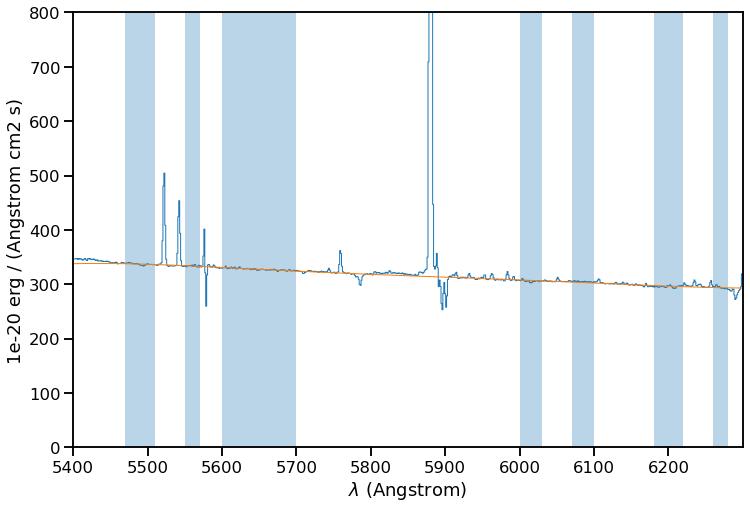

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
cubeA[:, 275:300, 120:150].mean(axis=(1, 2)).plot()
contA[:, 275:300, 120:150].mean(axis=(1, 2)).plot()
for wavrange in wavranges:
    ax.axvspan(*wavrange, alpha=0.3)
ax.set(ylim=[0, 800])

I had to go back and forth a few times adjusting the wav ranges.  It is difficult to get a good fit on the blue side because of the WR features.

As can be seen here, the final version is not perfect – it slightly overpredicts the continuum around 4700 to 4800.  This might affect some of the weak [Fe III] lines, but the [Ar IV] 4740 does not seem to be much affected.

### Look at some line images

Text(0.5, 1.0, 'Si II 5979')

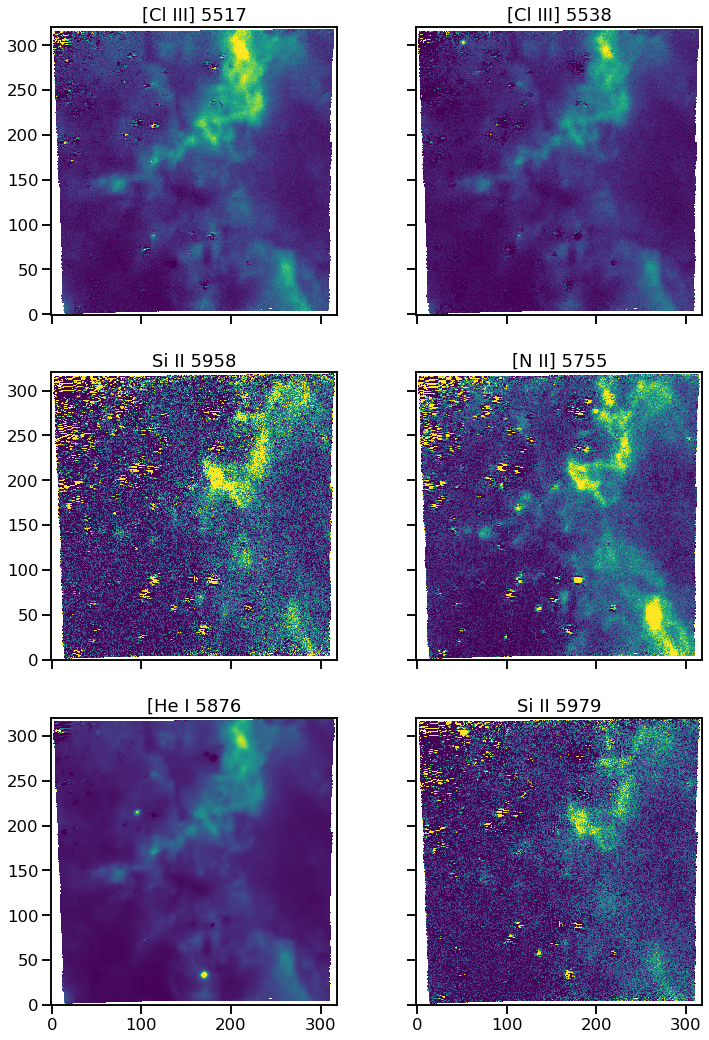

In [28]:
fig, axes = plt.subplots(3, 2, figsize=(12, 18), sharex=True, sharey=True)
(cubeA - contA).select_lambda(5517, 5527).sum(axis=0).plot(
    ax=axes[0, 0],
    vmin=-10,
    vmax=2000,
)
axes[0, 0].set_title("[Cl III] 5517")
(cubeA - contA).select_lambda(5538, 5548).sum(axis=0).plot(
    ax=axes[0, 1],
    vmin=-10,
    vmax=2000,
)
axes[0, 1].set_title("[Cl III] 5538")
(cubeA - contA).select_lambda(5958, 5968).sum(axis=0).plot(
    ax=axes[1, 0],
    vmin=-10,
    vmax=200,
)
axes[1, 0].set_title("Si II 5958")
(cubeA - contA).select_lambda(5755, 5765).sum(axis=0).plot(
    ax=axes[1, 1],
    vmin=-10,
    vmax=600,
)
axes[1, 1].set_title("[N II] 5755")
(cubeA - contA).select_lambda(5876, 5886).sum(axis=0).plot(
    ax=axes[2, 0],
    vmin=-10,
    vmax=90000,
)
axes[2, 0].set_title("[He I 5876")
(cubeA - contA).select_lambda(5979, 5989).sum(axis=0).plot(
    ax=axes[2, 1],
    vmin=-10,
    vmax=300,
)
axes[2, 1].set_title("Si II 5979")

## Now do the other fields

In [24]:
contB = extract.fit_continuum(
    cubeB,
    wav_ranges=wavranges,
    deg=5,
    median=False,
)

extract.fit_continuum: row 0


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1673: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100
extract.fit_continuum: row 110
extract.fit_continuum: row 120


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:346: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:414: RuntimeWarning: invalid value encountered in add
  return off + scl*x


extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240
extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


In [25]:
contC = extract.fit_continuum(
    cubeC,
    wav_ranges=wavranges,
    deg=5,
    median=False,
)

extract.fit_continuum: row 0
extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60
extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100
extract.fit_continuum: row 110
extract.fit_continuum: row 120


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1673: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:346: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:414: RuntimeWarning: invalid value encountered in add
  return off + scl*x


extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


In [26]:
contD = extract.fit_continuum(
    cubeD,
    wav_ranges=wavranges,
    deg=5,
    median=False,
)

extract.fit_continuum: row 0


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1673: RankWarning: The fit may be poorly conditioned
  return pu._fit(chebvander, x, y, deg, rcond, full, w)


extract.fit_continuum: row 10
extract.fit_continuum: row 20
extract.fit_continuum: row 30
extract.fit_continuum: row 40
extract.fit_continuum: row 50
extract.fit_continuum: row 60


/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:345: RuntimeWarning: divide by zero encountered in double_scalars
  off = (old[1]*new[0] - old[0]*new[1])/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:346: RuntimeWarning: divide by zero encountered in true_divide
  scl = newlen/oldlen
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/polynomial/polyutils.py:414: RuntimeWarning: invalid value encountered in add
  return off + scl*x


extract.fit_continuum: row 70
extract.fit_continuum: row 80
extract.fit_continuum: row 90
extract.fit_continuum: row 100
extract.fit_continuum: row 110
extract.fit_continuum: row 120
extract.fit_continuum: row 130
extract.fit_continuum: row 140
extract.fit_continuum: row 150
extract.fit_continuum: row 160
extract.fit_continuum: row 170
extract.fit_continuum: row 180
extract.fit_continuum: row 190
extract.fit_continuum: row 200
extract.fit_continuum: row 210
extract.fit_continuum: row 220
extract.fit_continuum: row 230
extract.fit_continuum: row 240
extract.fit_continuum: row 250
extract.fit_continuum: row 260
extract.fit_continuum: row 270
extract.fit_continuum: row 280
extract.fit_continuum: row 290
extract.fit_continuum: row 300
extract.fit_continuum: row 310
extract.fit_continuum: row 320


## Save the continuum-subtracted cubes

In [27]:
csub = {}
cdiv = {}
for cube, cont, label in zip(
    [cubeD, cubeC, cubeB, cubeA],
    [contD, contC, contB, contA],
    "DCBA",
):
    prefix = f"../big-data/lmc-30dor-{label}-subcube-54-63"
    csub[label] = cube - cont
    cdiv[label] = cube / cont
    csub[label].write(
        f"{prefix}-contsub.fits",
        savemask="nan",
    )
    cdiv[label].write(
        f"{prefix}-contdiv.fits",
        savemask="nan",
    )
    cont.write(
        f"{prefix}-cont.fits",
        savemask="nan",
    )

/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)
/Users/will/miniconda3/envs/py39/lib/python3.9/site-packages/mpdaf/obj/arithmetic.py:124: RuntimeWarning: invalid value encountered in true_divide
  var /= (b_data ** 4)
